In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 
PARENT_DIR = '/content/drive/MyDrive/cs287/CS287-final-project/'

Mounted at /content/drive


In [ ]:
#check gpu connection
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Dec  3 22:16:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#check high-ram connection
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# process data, tatoeba project

In [ ]:
#tatoeba dataset
#source: http://www.manythings.org/anki/
#downloaded 'fra-eng.zip' file

# #load full data
# tatoeba_df = pd.read_csv(f'{PARENT_DIR}tatoeba/fra.txt', sep='\t', header=None)
# #take a random subset
# n_sentences_total = tatoeba_df.shape[0]
# start = int((n_sentences_total/20)*19) #sample from the last chunk of data because early sentences are very short
# end = n_sentences_total
# tatoeba_df_subset = tatoeba_df.iloc[start:end, :].sample(n=2500, random_state=12345, axis='index')

# #save random subset
# tatoeba_df_subset.to_pickle(f'{PARENT_DIR}tatoeba/tatoeba_df_subset.pkl')

#load random subset
tatoeba_df_subset = pd.read_pickle(f'{PARENT_DIR}tatoeba/tatoeba_df_subset.pkl')

## source: english

english, #sentences: 2500
english, #words in shortest sentence: 6
english, #words in longest sentence: 34
english, average #words in sentence: 12.4808


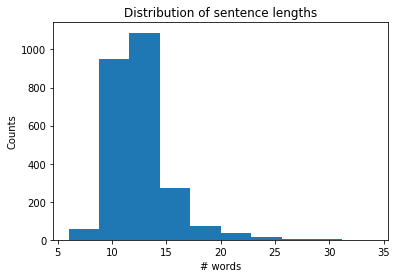

In [ ]:
#source language
tatoeba_en = list(tatoeba_df_subset[0])

#examine dataset
tatoeba_en_sentence_lengths = [len(sentence.split()) for sentence in tatoeba_en]
tatoeba_len_longest_sentence = max(tatoeba_en_sentence_lengths) #used as argument when getting topk translations
print('english, #sentences:', len(tatoeba_en))
print('english, #words in shortest sentence:', min(tatoeba_en_sentence_lengths))
print('english, #words in longest sentence:', max(tatoeba_en_sentence_lengths))
print('english, average #words in sentence:', np.mean(tatoeba_en_sentence_lengths))

plt.hist(tatoeba_en_sentence_lengths)
plt.title('Distribution of sentence lengths')
plt.xlabel('# words')
plt.ylabel('Counts');

In [ ]:
#add conditioning in front of each sentence
tatoeba_en = ['translate English to French: ' + sentence for sentence in tatoeba_en]
display(tatoeba_en[0:10])

['translate English to French: It is difficult to get him to do anything on the spur of the moment.',
 "translate English to French: I'd rather clean my room than spend time doing my homework.",
 'translate English to French: We desperately need more money to help fund our project.',
 'translate English to French: If you want me to help you, all you have to do is ask.',
 'translate English to French: The world was on the very brink of nuclear war during the Cuban Missile Crisis in October 1962.',
 'translate English to French: The president is expected to put forward a new energy policy.',
 'translate English to French: I planted various fruit trees on my property three years ago.',
 "translate English to French: I honestly think it's better to be a failure at something you love than to be a success at something you hate.",
 'translate English to French: If you tell a lie enough times, you begin to believe it.',
 "translate English to French: I would've told you before, but I didn't th

In [ ]:
#batch dataset: create a list of lists
n_sentences = len(tatoeba_en)
batch_size = 1
n_batches = n_sentences/batch_size
tatoeba_en_batched = np.array_split(tatoeba_en, n_batches) #creates list of 100 arrays
tatoeba_en_batched = list(map(list, tatoeba_en_batched)) #now have list of 100 lists

#print head
tatoeba_en_batched[0:3]

[['translate English to French: It is difficult to get him to do anything on the spur of the moment.'],
 ["translate English to French: I'd rather clean my room than spend time doing my homework."],
 ['translate English to French: We desperately need more money to help fund our project.']]

## reference: french

french, #sentences: 2500
french, #words in shortest sentence: 6
french, #words in longest sentence: 47
french, average #words in sentence: 13.2272


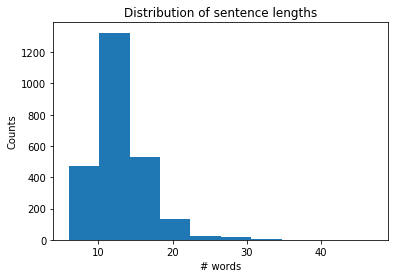

In [ ]:
#reference language
tatoeba_fr = list(tatoeba_df_subset[1])

#examine dataset
tatoeba_fr_sentence_lengths = [len(sentence.split()) for sentence in tatoeba_fr]

print('french, #sentences:', len(tatoeba_fr))
print('french, #words in shortest sentence:', min(tatoeba_fr_sentence_lengths))
print('french, #words in longest sentence:', max(tatoeba_fr_sentence_lengths))
print('french, average #words in sentence:', np.mean(tatoeba_fr_sentence_lengths))

plt.hist(tatoeba_fr_sentence_lengths)
plt.title('Distribution of sentence lengths')
plt.xlabel('# words')
plt.ylabel('Counts');

# calculate BLEU scores

In [ ]:
from torchtext.data.metrics import bleu_score

In [ ]:
#function that formats translations to calculate bleu scores 
def calc_bleu_score(translations, references):
    translations_formatted = [translation.split() for translation in translations]
    references_formatted = [[translation.split()] for translation in references]
    return bleu_score(translations_formatted, references_formatted)

In [ ]:
#function that calculates bleu scores from MBR decoding file outputs
def calc_bleu_score_from_file(filename):
  with open(f'{PARENT_DIR}MBR/{filename}') as file:
      translations = file.readlines()
  return calc_bleu_score(translations=translations, references=tatoeba_fr)


# plots

## BLEU score

###one example

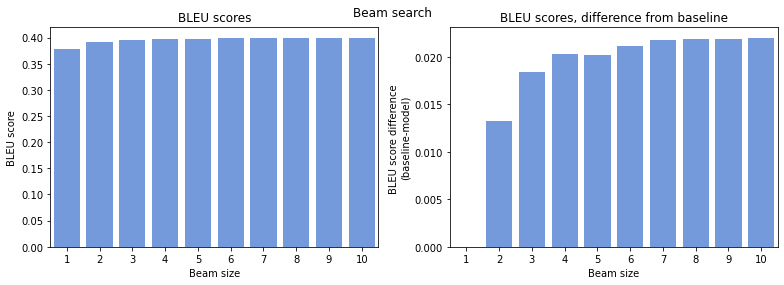

In [ ]:
###plot bleu score

#arguments
translation_files = [f'baseline_beam_beam{i}_n1.txt' for i in range(1, 11)]
translation_file_baseline = 'baseline_beam_beam1_n1.txt'
x_values = list(range(1, 11))
x_label= 'Beam size'
title='BLEU scores'
title_diff='BLEU scores, difference from baseline'
title_sup = 'Beam search'

#calculate bleu scores
bleu_scores = [calc_bleu_score_from_file(filename=file) for file in translation_files]
baseline_bleu_score = calc_bleu_score_from_file(filename=translation_file_baseline)
bleu_scores_diff_from_baseline = [score - baseline_bleu_score for score in bleu_scores]

#plot bleu scores
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

df = pd.DataFrame(zip(x_values, bleu_scores))
y_label='BLEU score'
df.columns = [x_label, y_label]
sns.barplot(x=x_label, y=y_label, data=df, color='cornflowerblue', ax=axes[0]).set_title(title);

#plot bleu scores, difference from baseline
df_diff = pd.DataFrame(zip(x_values, bleu_scores_diff_from_baseline))
y_label='BLEU score difference \n(baseline-model)'
df_diff.columns = [x_label, y_label]
sns.barplot(x=x_label, y=y_label, data=df_diff, color='cornflowerblue', ax=axes[1]).set_title(title_diff);

fig.suptitle(title_sup)
fig.tight_layout()

In [ ]:
bleu_scores

[0.37735436171414116,
 0.3905547744010974,
 0.3957303032462871,
 0.39765943892568373,
 0.39751948518368896,
 0.39855040883882037,
 0.39918372251224055,
 0.3992722743742265,
 0.3992911551059502,
 0.3993622835062952]

In [ ]:
bleu_scores_diff_from_baseline

[0.0,
 0.013200412686956264,
 0.018375941532145945,
 0.020305077211542566,
 0.020165123469547797,
 0.021196047124679207,
 0.021829360798099384,
 0.02191791266008536,
 0.02193679339180904,
 0.02200792179215405]

### function

In [ ]:
###plot bleu score

def plot_bleu_scores(translation_files, translation_file_baseline, x_values, x_label, title_sup,
                     title='BLEU scores', title_diff='BLEU scores, difference from baseline'):
    #calculate bleu scores
    bleu_scores = [calc_bleu_score_from_file(filename=file) for file in translation_files]
    baseline_bleu_score = calc_bleu_score_from_file(filename=translation_file_baseline)
    bleu_scores_diff_from_baseline = [score - baseline_bleu_score for score in bleu_scores]

    #plot bleu scores
    fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

    df = pd.DataFrame(zip(x_values, bleu_scores))
    y_label='BLEU score'
    df.columns = [x_label, y_label]
    bleu_plot = sns.barplot(x=x_label, y=y_label, data=df, color='cornflowerblue', ax=axes[0])

    for p in bleu_plot.patches:
        bleu_plot.annotate(format(p.get_height(), '.3f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', 
                          xytext = (0, -12), 
                          textcoords = 'offset points')
        
    bleu_plot.axhline(baseline_bleu_score, color='tomato')

    bleu_plot.set_title(title)

    #plot bleu scores, difference from baseline
    df_diff = pd.DataFrame(zip(x_values, bleu_scores_diff_from_baseline))
    y_label='BLEU score difference \n(baseline-condition)'
    df_diff.columns = [x_label, y_label]
    diff_plot = sns.barplot(x=x_label, y=y_label, data=df_diff, color='cornflowerblue', ax=axes[1])
    diff_plot.set_title(title_diff);

    fig.suptitle(title_sup, y = 1.03)
    fig.tight_layout()

    return bleu_scores, baseline_bleu_score, bleu_scores_diff_from_baseline

### beam search

([0.37735436171414116,
  0.3905547744010974,
  0.3957303032462871,
  0.39765943892568373,
  0.39751948518368896,
  0.39855040883882037,
  0.39918372251224055,
  0.3992722743742265,
  0.3992911551059502,
  0.3993622835062952],
 0.39751948518368896,
 [-0.020165123469547797,
  -0.006964710782591532,
  -0.0017891819374018514,
  0.0001399537419947694,
  0.0,
  0.0010309236551314105,
  0.0016642373285515877,
  0.0017527891905375625,
  0.001771669922261243,
  0.0018427983226062539])

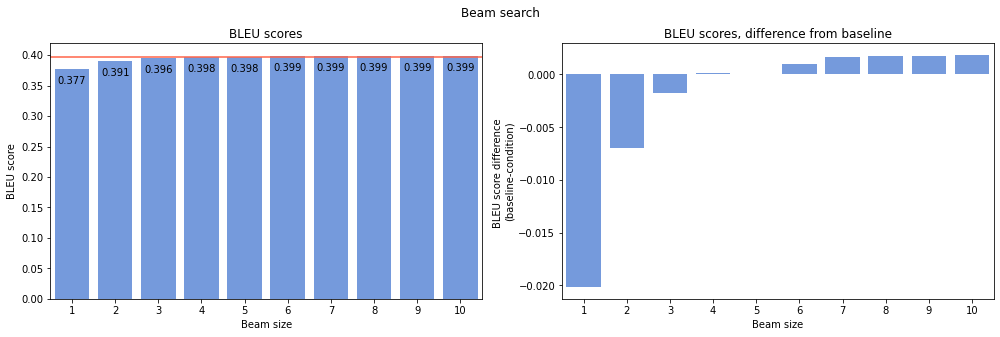

In [ ]:
#arguments
beams = list(range(1, 11))
translation_files = [f'baseline_beam_beam{b}_n1.txt' for b in beams]
translation_file_baseline = 'baseline_beam_beam5_n1.txt' #note this baseline!!!
x_values = beams
x_label= 'Beam size'
title_sup = 'Beam search'

plot_bleu_scores(translation_files, translation_file_baseline, x_values, x_label, title_sup)

### beam search + MBR

([0.37735436171414116,
  0.3887099600986849,
  0.39373101386324655,
  0.39644563134936944,
  0.39584857902469645,
  0.3981501869745115,
  0.3955365726300873,
  0.3956786830990781,
  0.39610230547044184,
  0.39575863967110175],
 0.39751948518368896,
 [-0.020165123469547797,
  -0.008809525085004044,
  -0.0037884713204424103,
  -0.0010738538343195159,
  -0.0016709061589925134,
  0.0006307017908225299,
  -0.001982912553601668,
  -0.0018408020846108486,
  -0.0014171797132471187,
  -0.0017608455125872058])

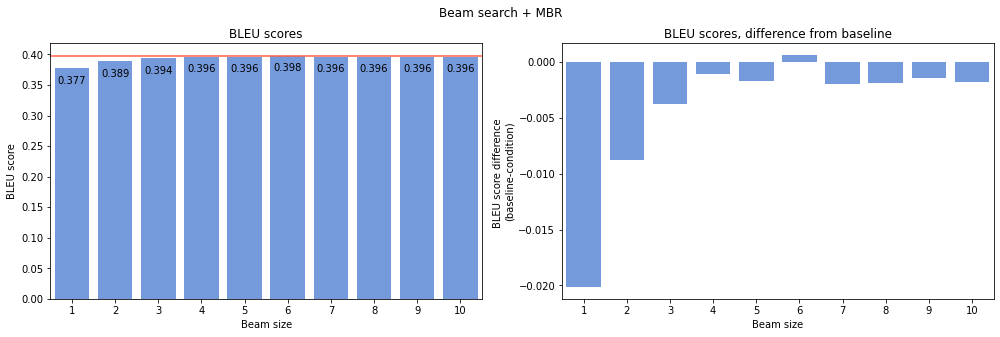

In [ ]:
#arguments
beams = list(range(1, 11))
translation_files = [f'samples_ancestral_n200_candidates_beam_beam{b}_translations.txt' for b in beams]
translation_file_baseline = 'baseline_beam_beam5_n1.txt'
x_values = beams
x_label= 'Beam size'
title_sup = 'Beam search + MBR\n'

plot_bleu_scores(translation_files, translation_file_baseline, x_values, x_label, title_sup)

### ancestral sampling + MBR (just #s)

In [ ]:
#bleu score
calc_bleu_score_from_file(filename='samples_ancestral_n200_basic_candidates_ancestral_n1000_translations.txt')

0.39348789175529625

In [ ]:
#difference from baseline
calc_bleu_score_from_file(filename='samples_ancestral_n200_basic_candidates_ancestral_n1000_translations.txt')-calc_bleu_score_from_file(filename='baseline_beam_beam5_n1.txt')

-0.00403159342839271

### top-k sampling + MBR

([0.39054744111251294,
  0.39071060764340815,
  0.39195542709348363,
  0.39155866076439927,
  0.39212182854420496,
  0.38929691868059896,
  0.39023730831324277,
  0.3916619327211991,
  0.39244122816684884,
  0.3899202539175543],
 0.39751948518368896,
 [-0.00697204407117602,
  -0.006808877540280811,
  -0.005564058090205326,
  -0.00596082441928969,
  -0.005397656639483994,
  -0.00822256650309,
  -0.007282176870446189,
  -0.005857552462489868,
  -0.005078257016840115,
  -0.007599231266134654])

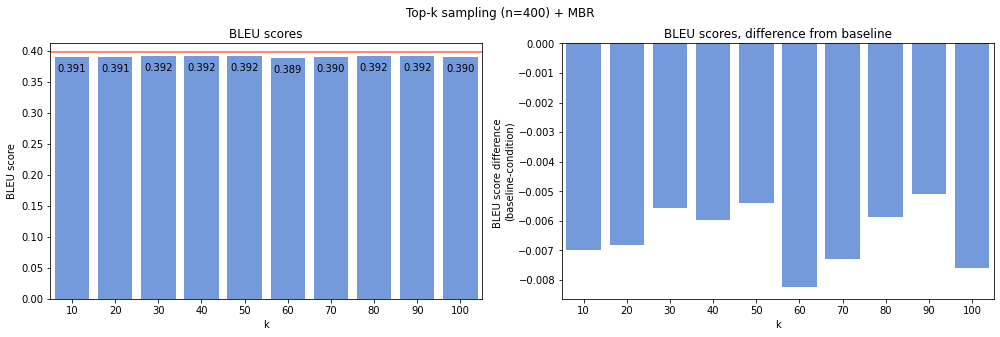

In [ ]:
#arguments, full
ks = list(range(10, 110, 10))
translation_files = [f'samples_ancestral_n200_candidates_topk_k{k}_n400_translations.txt' for k in ks]
translation_file_baseline = 'baseline_beam_beam5_n1.txt'
x_values = ks
x_label= 'k'
title_sup = 'Top-k sampling (n=400) + MBR'

plot_bleu_scores(translation_files, translation_file_baseline, x_values, x_label, title_sup)

### top-p sampling + MBR

([0.37760197672880275,
  0.37871486362713236,
  0.3815449968704743,
  0.3861147308377125,
  0.38962492341014887,
  0.39216761469715233,
  0.39253676508230795,
  0.3917029993324562,
  0.39298202994644554,
  0.3896562439555519],
 0.39751948518368896,
 [-0.019917508454886212,
  -0.0188046215565566,
  -0.015974488313214685,
  -0.011404754345976431,
  -0.007894561773540087,
  -0.005351870486536625,
  -0.004982720101381011,
  -0.005816485851232733,
  -0.004537455237243415,
  -0.007863241228137086])

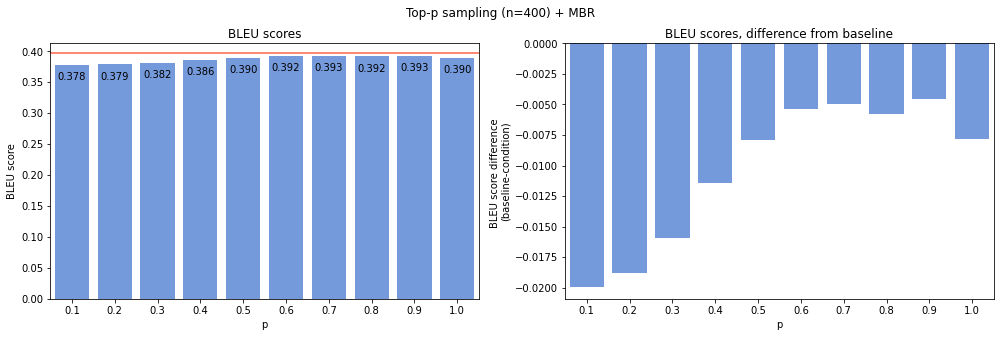

In [ ]:
#arguments, subset
ps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
translation_files = [f'samples_ancestral_n200_candidates_topp_p{p}_n400_translations.txt' for p in ps]
translation_file_baseline = 'baseline_beam_beam5_n1.txt'
x_values = [p/100 for p in ps]
x_label= 'p'
title_sup = 'Top-p sampling (n=400) + MBR'

plot_bleu_scores(translation_files, translation_file_baseline, x_values, x_label, title_sup)

### troubleshooting

In [ ]:
with open('/content/drive/MyDrive/cs287/CS287-final-project/MBR/samples_ancestral_n200_candidates_topp_p10_n400_translations.txt') as file:
    translations = file.readlines()
    #print('beam, beam5, mbr:', calc_bleu_score(translations=tatoeba_enfr_beam_beam5_mbr, references=tatoeba_fr))

#translations = file.readlines()
references = tatoeba_fr


translations_formatted = [translation.split() for translation in translations]
references_formatted = [[translation.split()] for translation in references]
bleu_score(translations_formatted, references_formatted)

0.37760197672880275

In [ ]:
references

["Il est difficile de lui faire faire quoi que ce soit sous l'impulsion du moment.",
 'Je ferais mieux de nettoyer ma chambre que de passer du temps à faire mes devoirs.',
 "Nous avons désespérément besoin de davantage d'argent pour aider à financer notre projet.",
 'Si tu veux que je vous aide, tout ce que tu as à faire est de demander.',
 "Le monde était tout au bord d'une guerre nucléaire, lors de la crise des missiles de Cuba, en octobre dix-neuf-cent-soixante-deux.",
 "On s'attend à ce que le président propose une nouvelle politique énergétique.",
 "J'ai planté divers arbres fruitiers dans ma propriété il y a trois ans.",
 "Je pense sincèrement qu'il est préférable d'échouer à quelque chose que l'on adore plutôt que d'avoir du succès à quelque chose que l'on déteste.",
 'Si vous racontez un mensonge suffisamment de fois, vous vous mettez à le croire.',
 "Je te l'aurais dit plus tôt, mais je ne pensais pas que tu comprendrais.",
 'Je veux juste que vous sachiez que je ne serai pas 

In [ ]:
translations

["Il est difficile de le faire en l'état de l'heure.\n",
 "J'aimerais plutôt nettoyer ma chambre plutôt que de passer du temps à faire mes devoirs.\n",
 "Nous avons désespérément besoin d'un plus grand financement pour notre projet.\n",
 'Si vous voulez que je vous aide, il suffit de vous en informer.\n',
 "Le monde était au bord de la guerre nucléaire durant la crise des missiles cubains d'octobre 1962.\n",
 'Le président devrait proposer une nouvelle politique énergétique.\n',
 "J'ai planté divers arbres fruitiers sur ma propriété il y a trois ans.\n",
 "Je pense sincèrement qu'il est préférable d'être un échec dans un domaine que l'on aime plutôt que d'être un succès dans un domaine que l'on a détesté.\n",
 'Si vous dites un mensonge assez souvent, vous commencez à le croire.\n',
 'Je vous auraiti déjà dit cela, mais je ne crois pas que vous compreniez.\n',
 'Je veux simplement que vous sachiez que je ne serai pas en mesure de vous rendre à votre pique-nique.\n',
 'Il avait cette ha

In [ ]:
len(translations)

2500

In [ ]:
calc_bleu_score_from_file(filename='samples_ancestral_n200_candidates_topp_p10_n400_translations.txt')

0.37760197672880275

In [ ]:
calc_bleu_score_from_file(filename='samples_ancestral_n200_candidates_topp_p20_n400_translations.txt')

0.37871486362713236

In [ ]:
calc_bleu_score_from_file(filename='samples_ancestral_n200_candidates_topp_p30_n400_translations.txt')

0.3815449968704743

In [ ]:
calc_bleu_score_from_file(filename='samples_ancestral_n200_candidates_topp_p40_n400_translations.txt')

0.3861147308377125

## length bias

### one example

In [ ]:
#calculate length of each reference sentence
references_formatted = [[translation.split()] for translation in tatoeba_fr]
reference_lengths = [len(sentence[0]) for sentence in references_formatted]

reference_avg_length = np.mean(reference_lengths)
reference_avg_length

13.2272

In [ ]:
#arguments
translation_files = [f'samples_ancestral_n200_candidates_beam_beam{b}_translations.txt' for b in beams]

translation_lengths_diff_distrs = []
translation_lengths_avgs = []

for filename in translation_files:
    #load and format translations
    with open(f'{PARENT_DIR}MBR/{filename}') as file:
        translations = file.readlines()
    translations_formatted = [translation.split() for translation in translations]

    #calculate distr of pairwise length differences
    translation_lengths = [len(sentence) for sentence in translations_formatted]
    length_diffs = [ref - transl for ref, transl in zip(reference_lengths, translation_lengths)] #reference - translation
    translation_lengths_diff_distrs.append(length_diffs) 
    
    #calculate average length of translations
    translation_avg_length = np.mean(translation_lengths)
    translation_lengths_avgs.append(translation_avg_length)

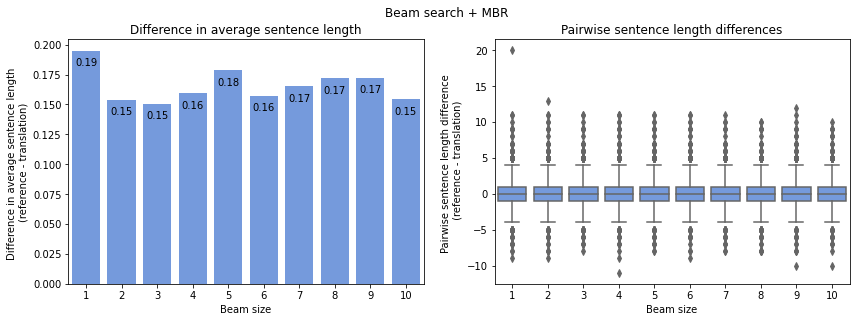

In [ ]:
#arguments
x_values = list(range(1, 11))
x_label = 'Beam size'
title_avg = 'Difference in average sentence length'
title_distr = 'Pairwise sentence length differences'
title_sup = 'Beam search + MBR'

diff_lengths_avgs = reference_avg_length - translation_lengths_avgs #reference - translation
df_avg = pd.DataFrame(zip(x_values, diff_lengths_avgs))
y_label='Difference in average sentence length \n(reference - translation)'
df_avg.columns = [x_label, y_label]



#plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

###average difference plot
avg_plot = sns.barplot(x=x_label, y=y_label, data=df_avg, color='cornflowerblue', ax=axes[0])

for p in avg_plot.patches:
    avg_plot.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, -12), 
                      textcoords = 'offset points')

avg_plot.set_title(title_avg)

###pairwise difference distribution plot
y_label = 'Pairwise sentence length difference \n (reference - translation)'
df_distr = pd.DataFrame(columns=[x_label, y_label])

#create df: col1=x_value, col2=pairwise difference
for i, x in enumerate(x_values):
    df = pd.DataFrame(zip([x]*2500, translation_lengths_diff_distrs[i]))
    df.columns = [x_label, y_label]
    df_distr = df_distr.append(df)
  
distr_plot = sns.boxplot(x=x_label, y=y_label, data=df_distr, color='cornflowerblue', ax=axes[1])
distr_plot.set_title(title_distr)

fig.suptitle(title_sup);

### function

In [ ]:
def plot_length_analysis(translation_files, x_values, x_label, title_sup, 
                         title_avg='Difference in average sentence length', title_distr='Pairwise sentence length differences'):

    #####calculate length statistics

    translation_lengths_diff_distrs = []
    translation_lengths_avgs = []
    for filename in translation_files:
        #load and format translations
        with open(f'{PARENT_DIR}MBR/{filename}') as file:
            translations = file.readlines()
        translations_formatted = [translation.split() for translation in translations]

        #calculate distr of pairwise length differences
        translation_lengths = [len(sentence) for sentence in translations_formatted]
        length_diffs = [ref - transl for ref, transl in zip(reference_lengths, translation_lengths)] #reference - translation
        translation_lengths_diff_distrs.append(length_diffs) 
        
        #calculate average length of translations
        translation_avg_length = np.mean(translation_lengths)
        translation_lengths_avgs.append(translation_avg_length)

    #####plots

    #plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

    ###average difference plot
    #format data
    diff_lengths_avgs = reference_avg_length - translation_lengths_avgs #reference - translation
    df_avg = pd.DataFrame(zip(x_values, diff_lengths_avgs))
    y_label='Difference in average sentence length \n(reference - translation)'
    df_avg.columns = [x_label, y_label]

    #plot
    avg_plot = sns.barplot(x=x_label, y=y_label, data=df_avg, color='cornflowerblue', ax=axes[0])

    for p in avg_plot.patches:
        avg_plot.annotate(format(p.get_height(), '.3f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', 
                          xytext = (0, -12), 
                          textcoords = 'offset points')

    avg_plot.set_title(title_avg)

    ###pairwise difference distribution plot

    #format data
    y_label = 'Pairwise sentence length difference \n (reference - translation)'
    df_distr = pd.DataFrame(columns=[x_label, y_label])

    for i, x in enumerate(x_values): #create df: col1=x_value, col2=pairwise difference
        df = pd.DataFrame(zip([x]*2500, translation_lengths_diff_distrs[i]))
        df.columns = [x_label, y_label]
        df_distr = df_distr.append(df)

    #plot
    distr_plot = sns.boxplot(x=x_label, y=y_label, data=df_distr, color='cornflowerblue', ax=axes[1])
    distr_plot.set_title(title_distr)

    fig.suptitle(title_sup);

    ###statistics to return

    translation_pairwise_avgs = [np.mean(distr) for distr in translation_lengths_diff_distrs]
    
    return translation_lengths_avgs, translation_pairwise_avgs

### beam search

([13.0324,
  13.0776,
  13.0948,
  13.1136,
  13.1012,
  13.102,
  13.1028,
  13.1112,
  13.1,
  13.1132],
 [0.1948, 0.1496, 0.1324, 0.1136, 0.126, 0.1252, 0.1244, 0.116, 0.1272, 0.114])

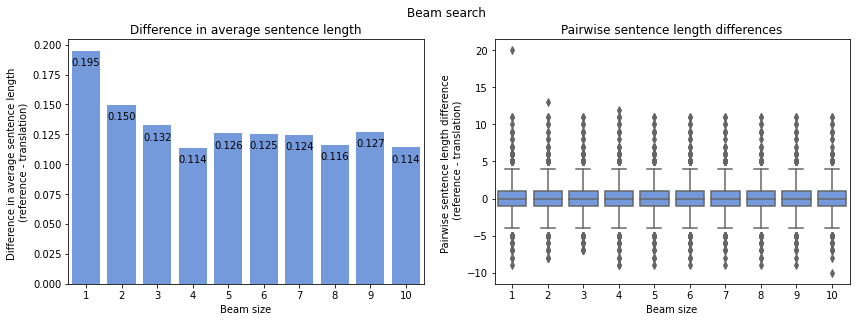

In [ ]:
#arguments
beams = list(range(1, 11))
translation_files = [f'baseline_beam_beam{b}_n1.txt' for b in beams]
x_values = beams
x_label = 'Beam size'
title_sup = 'Beam search'

plot_length_analysis(translation_files, x_values, x_label, title_sup)


### beam search + MBR

([13.0324,
  13.0732,
  13.0768,
  13.068,
  13.0488,
  13.07,
  13.062,
  13.0552,
  13.0548,
  13.0728],
 [0.1948,
  0.154,
  0.1504,
  0.1592,
  0.1784,
  0.1572,
  0.1652,
  0.172,
  0.1724,
  0.1544])

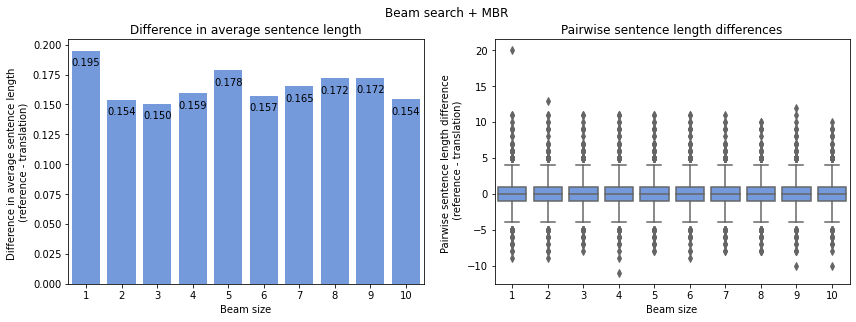

In [ ]:
#arguments
beams = list(range(1, 11))
translation_files = [f'samples_ancestral_n200_candidates_beam_beam{b}_translations.txt' for b in beams]
x_values = beams
x_label = 'Beam size'
title_sup = 'Beam search + MBR'

plot_length_analysis(translation_files, x_values, x_label, title_sup)


### ancestral sampling + MBR 

In [ ]:
#calculate difference in average sentence length

#arguments
translation_files = 'samples_ancestral_n200_basic_candidates_ancestral_n1000_translations.txt'

translation_lengths_diff_distrs = []
translation_lengths_avgs = []

with open(f'{PARENT_DIR}MBR/{translation_files}') as file:
    translations = file.readlines()
translations_formatted = [translation.split() for translation in translations]

#calculate distr of pairwise length differences
translation_lengths = [len(sentence) for sentence in translations_formatted]
length_diffs = [ref - transl for ref, transl in zip(reference_lengths, translation_lengths)] #reference - translation

#calculate average length of translations
translation_avg_length = np.mean(translation_lengths)

print('avg. sentence length, ref: ', reference_avg_length)
print('avg. sentence length, transl: ', translation_avg_length)
print('difference in avg. sentence length (ref-transl): ', reference_avg_length - translation_avg_length)

avg. sentence length, ref:  13.2272
avg. sentence length, transl:  12.9904
difference in avg. sentence length (ref-transl):  0.23680000000000057


[Text(0, 0.5, 'Pairwise sentence length difference \n (reference - translation)'),
 Text(0.5, 1.0, 'Ancestral sampling (n=1000)')]

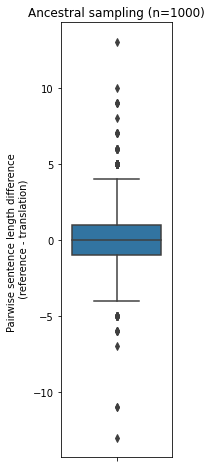

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(2, 8))

bplot = sns.boxplot(y=length_diffs, orient="v")

bplot.set(ylabel='Pairwise sentence length difference \n (reference - translation)', 
          title='Ancestral sampling (n=1000)')


In [ ]:
np.mean(length_diffs)

0.2368

### top-k sampling + MBR

([12.9812,
  13.0176,
  12.9736,
  12.9796,
  12.9712,
  12.9888,
  12.9944,
  12.978,
  13.0108,
  12.9784],
 [0.246,
  0.2096,
  0.2536,
  0.2476,
  0.256,
  0.2384,
  0.2328,
  0.2492,
  0.2164,
  0.2488])

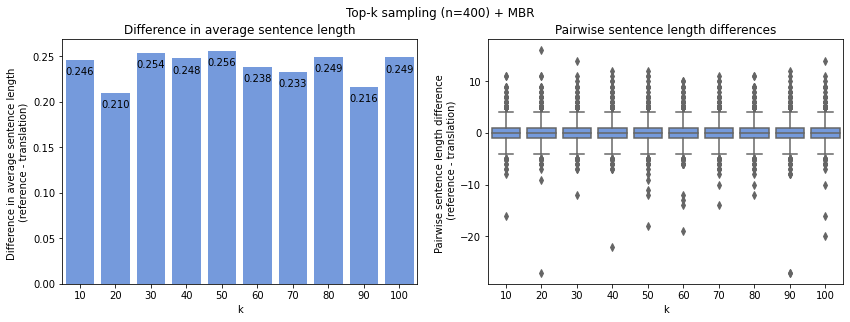

In [ ]:
#arguments
ks = list(range(10, 110, 10))
translation_files = [f'samples_ancestral_n200_candidates_topk_k{k}_n400_translations.txt' for k in ks]
x_values = ks
x_label= 'k'
title_sup = 'Top-k sampling (n=400) + MBR'

plot_length_analysis(translation_files, x_values, x_label, title_sup)


### top-p sampling + MBR

([13.042,
  13.0364,
  12.9976,
  12.9896,
  12.9912,
  12.9988,
  12.9752,
  12.9788,
  12.992,
  12.9992],
 [0.1852, 0.1908, 0.2296, 0.2376, 0.236, 0.2284, 0.252, 0.2484, 0.2352, 0.228])

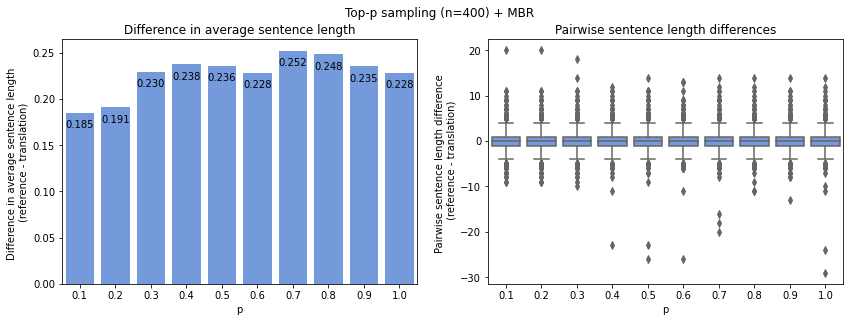

In [ ]:
#arguments
ps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
translation_files = [f'samples_ancestral_n200_candidates_topp_p{p}_n400_translations.txt' for p in ps]
x_values = [p/100 for p in ps]
x_label= 'p'
title_sup = 'Top-p sampling (n=400) + MBR'

plot_length_analysis(translation_files, x_values, x_label, title_sup)


In [ ]:
filename='samples_ancestral_n200_candidates_topp_p10_n400_translations.txt'
with open(f'/content/drive/MyDrive/cs287/CS287-final-project/MBR/{filename}') as file:
    translations = file.readlines()
    #print('beam, beam5, mbr:', calc_bleu_score(translations=tatoeba_enfr_beam_beam5_mbr, references=tatoeba_fr))

#translations = file.readlines()
references = tatoeba_fr


translations_formatted = [translation.split() for translation in translations]
references_formatted = [[translation.split()] for translation in references]
bleu_score(translations_formatted, references_formatted)

In [ ]:
calc_bleu_score_from_file('samples_ancestral_n200_candidates_topk_k100_n400_translations.txt')

0.3899202539175543

## scratch

In [ ]:

# print('greedy:', calc_bleu_score(translations=tatoeba_enfr_greedy, references=tatoeba_fr))
# print('beam, beam5, top1:', calc_bleu_score(translations=tatoeba_enfr_beam_beam5_top1, references=tatoeba_fr))
# print('top-k sampling, k=20, top1:', calc_bleu_score(translations=tatoeba_enfr_topk_k20_top1, references=tatoeba_fr))
# print('top-k sampling, k=50, top1:', calc_bleu_score(translations=tatoeba_enfr_topk_k50_top1, references=tatoeba_fr))
# print('ancestral sampling, top1:', calc_bleu_score(translations=tatoeba_enfr_ancestral_top1, references=tatoeba_fr))
# print('nucleus sampling, p=0.50, top1:', calc_bleu_score(translations=tatoeba_enfr_nucleus_p50_top1, references=tatoeba_fr))
# print('nucleus sampling, p=0.90, top1:', calc_bleu_score(translations=tatoeba_enfr_nucleus_p90_top1, references=tatoeba_fr))


greedy: 0.37735436171414116
beam, beam5, top1: 0.39751948518368896
top-k sampling, k=20, top1: 0.2056148797273636
top-k sampling, k=50, top1: 0.19476744532585144
ancestral sampling, top1: 0.17997339367866516
nucleus sampling, p=0.50, top1: 0.36389776091588677
nucleus sampling, p=0.90, top1: 0.2452133744955063


In [ ]:
#print(calc_bleu_score_from_file(filename='beam_beam5_translations.txt'))
#print(calc_bleu_score_from_file(filename='basic_candidates_topk_k10_n400_translations.txt'))
#print(calc_bleu_score_from_file(filename='basic_candidates_topp_p70_n400_translations.txt'))

# all with n = 200 samples and C2F decoding
print('Ancestral + MBR with candidates = 1000', calc_bleu_score_from_file(filename='samples_ancestral_n200_basic_candidates_ancestral_n1000_translations.txt'))
print('Beam + MBR with beam_size = 5', calc_bleu_score_from_file(filename='samples_ancestral_n200_basic_candidates_beam_beam5_translations.txt'))
print('Top-K + MBR with k = 10, n = 400', calc_bleu_score_from_file(filename='samples_ancestral_n200_basic_candidates_topk_k10_n400_translations.txt'))
print('Top-p + MBR with p = 70, n = 400', calc_bleu_score_from_file(filename='samples_ancestral_n200_basic_candidates_topp_p70_n400_translations.txt'))



Ancestral + MBR with candidates = 1000 0.39348789175529625
Beam + MBR with beam_size = 5 0.39716769512235695
Top-K + MBR with k = 10, n = 400 0.3917535408110421
Top-p + MBR with p = 70, n = 400 0.39253676508230795


In [ ]:
def translation_lengths_from_file(filename):
  with open(f'/content/drive/MyDrive/CS287-final-project/{filename}') as file:
      translations = file.readlines()
  
  return [len(s.split()) for s in translations]


beam          13.1012
beam + MBR    13.0484
topk + MBR    13.0484
dtype: float64

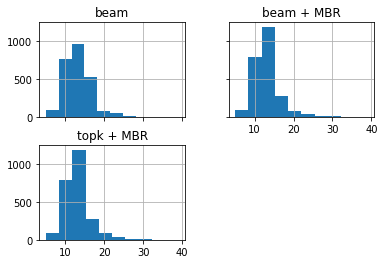

In [ ]:
df = pd.DataFrame({'beam' : translation_lengths_from_file(filename='topk_translations/tatoeba_enfr_beam_beam5_top1.txt'),
                   'beam + MBR' : translation_lengths_from_file(filename='MBR/beam_beam5_translations.txt'), 
                   'topk + MBR' : translation_lengths_from_file(filename='MBR/beam_beam5_translations.txt')})
df.hist(sharex=True, sharey=True)
df.mean()
#g = sns.FacetGrid(tips, col="time",  row="sex")
#g.map(sns.scatterplot, "total_bill", "tip")

12.9752


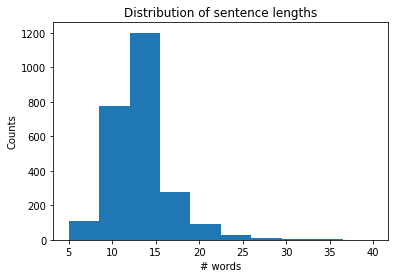

In [ ]:
lengths = avg_length_from_file(filename='samples_ancestral_n200_basic_candidates_topp_p70_n400_translations.txt')

plt.hist(lengths)
plt.title('Distribution of sentence lengths')
plt.xlabel('# words')
plt.ylabel('Counts');
print(np.mean(lengths))

13.0484


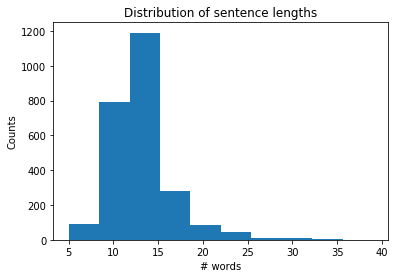

In [ ]:
lengths = avg_length_from_file(filename='beam_beam5_translations.txt')

plt.hist(lengths)
plt.title('Distribution of sentence lengths')
plt.xlabel('# words')
plt.ylabel('Counts');
print(np.mean(lengths))